In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, GaussianNoise
from tensorflow.keras import backend as K

## Read Dataset

In [ ]:
df = pd.read_csv('dataSetKopi_Bersih.csv')
df = df[['Species','Variety','Aroma','Flavor','Aftertaste','Acidity', 'Body', 'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points', 'Total.Cup.Points', 'Moisture']]
df

,Species,Variety,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture
0,Arabica,Other,8.75,8.67,8.50,8.58,8.42,8.42,10.00,10.00,10.00,8.58,89.92,0.12
1,Arabica,Bourbon,8.42,8.50,8.42,8.42,8.33,8.42,10.00,10.00,10.00,9.25,89.75,0.00
2,Arabica,Caturra,8.17,8.58,8.42,8.42,8.50,8.25,10.00,10.00,10.00,8.67,89.00,0.11
3,Arabica,Other,8.25,8.50,8.25,8.50,8.42,8.33,10.00,10.00,10.00,8.58,88.83,0.12
4,Arabica,Caturra,8.58,8.42,8.42,8.50,8.25,8.33,10.00,10.00,10.00,8.33,88.83,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,Robusta,Caturra,7.75,7.58,7.33,7.58,5.08,7.83,10.00,10.00,7.75,7.83,78.75,0.00
1334,Robusta,Caturra,7.50,7.67,7.75,7.75,5.17,5.25,10.00,10.00,8.42,8.58,78.08,0.00
1335,Robusta,Caturra,7.33,7.33,7.17,7.42,7.50,7.17,9.33,9.33,7.42,7.17,77.17,0.00
1336,Robusta,Caturra,7.42,6.83,6.75,7.17,7.25,7.00,9.33,9.33,7.08,6.92,75.08,0.10


## Process

## Import Lib

In [ ]:
features = ['Aroma','Flavor','Aftertaste','Acidity', 'Body', 'Balance',
            'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points',
            'Total.Cup.Points', 'Moisture']
X = df[features].values
y = df['Species']

In [ ]:
# 3. Normalisasi fitur
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# 4. Encode label
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
# 5. Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [ ]:
# 6. Oversampling dengan RandomOverSampler
from imblearn.under_sampling import ClusterCentroids

ros = ClusterCentroids(random_state=42)
# ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [ ]:
# 7. Reshape untuk LSTM
X_res_lstm = np.expand_dims(X_resampled, axis=1)
X_test_lstm = np.expand_dims(X_test, axis=1)

In [ ]:
# 8. One-hot encode label
y_res_cat = to_categorical(y_resampled)
y_test_cat = to_categorical(y_test)

In [ ]:
# 9. Clear session & Build Model
K.clear_session()

model = Sequential()
model.add(GaussianNoise(0.05, input_shape=(1, X_res_lstm.shape[2])))  # Sedikit noise
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y_res_cat.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# --- Train model ---
history = model.fit(
    X_res_lstm, y_res_cat,
    validation_data=(X_test_lstm, y_test_cat),
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 851ms/step - accuracy: 0.3210 - loss: 0.7778 - val_accuracy: 0.5522 - val_loss: 0.6883
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.5710 - loss: 0.6982 - val_accuracy: 0.6007 - val_loss: 0.6829
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4233 - loss: 0.7083 - val_accuracy: 0.6343 - val_loss: 0.6788
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.4896 - loss: 0.6898 - val_accuracy: 0.6604 - val_loss: 0.6753
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4640 - loss: 0.7146 - val_accuracy: 0.6903 - val_loss: 0.6722
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5663 - loss: 0.6712 - val_accuracy: 0.7090 - val_loss: 0.6692
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3977 - loss: 0.7167 - val_accuracy: 0.7313 - val_loss: 0.6665
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6023 - loss: 0.7135 - val_accuracy: 0.7537 - val_loss: 0.6638
Epoch

In [ ]:
score = model.evaluate(X_test_lstm, y_test_cat,verbose=0)
print("Accuracy: {}".format(score[1] * 100))

Accuracy: 86.56716346740723


In [ ]:
yhat = model.predict(X_test_lstm, verbose=0)
classes_x=np.argmax(yhat,axis=1)

In [ ]:
y_asdadasd = []
for data in y_test_cat:
  for i,item in enumerate(data):
    if item == 1:
      y_asdadasd.append(i)

npa = np.asarray(y_asdadasd)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.metrics import precision_recall_fscore_support as score

precision,recall,fscore,support=score(npa,classes_x,average='macro')
print('Precision : ',format(precision))
print('Recall    : ',format(recall))
print('F-score   : ',format(fscore))
print('Accuracy : ',accuracy_score(npa, classes_x))

Precision :  0.5603070175438596
Recall    :  0.8498727735368957
F-score   :  0.5719609582963621
Accuracy :  0.8656716417910447


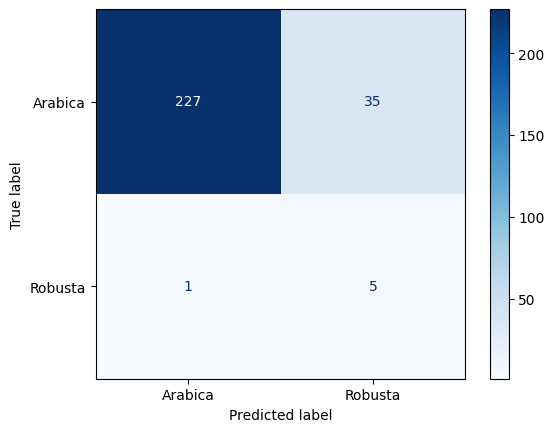

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels = ["Arabica", "Robusta"]

cm = confusion_matrix(npa, classes_x)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

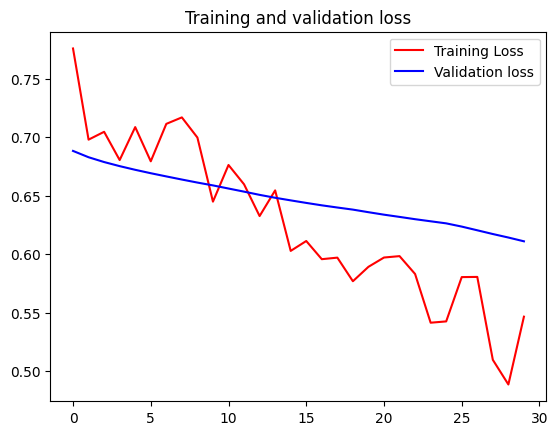

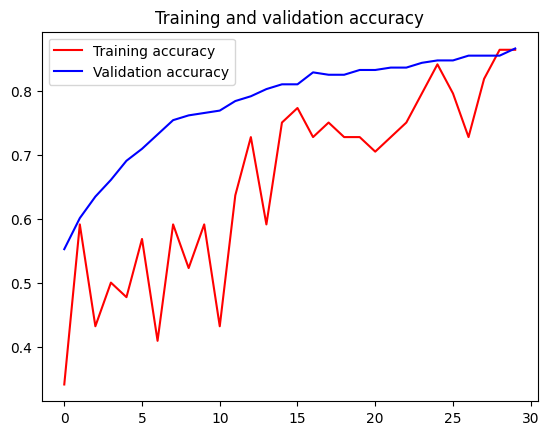

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()




plt.show()